In [1]:
!pip install torch scikeras skorch | grep -v 'Requirement already satisfied'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.3/239.3 kB 6.0 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import torch
import torch.nn
import torch.optim
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
from scikeras.wrappers import KerasRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error as mse, r2_score
from sklearn.multioutput import MultiOutputRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from skorch import NeuralNetRegressor
from tensorflow.keras import callbacks, layers, Sequential

In [3]:
filepath = '/kaggle/input/renewable-energy-and-weather-conditions/solar_weather.csv'

df = pd.read_csv(filepath, parse_dates = ['Time'])

display(df)

,Time,Energy delta[Wh],GHI,temp,pressure,humidity,wind_speed,rain_1h,snow_1h,clouds_all,isSun,sunlightTime,dayLength,SunlightTime/daylength,weather_type,hour,month
0,2017-01-01 00:00:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
1,2017-01-01 00:15:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
2,2017-01-01 00:30:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
3,2017-01-01 00:45:00,0,0.0,1.6,1021,100,4.9,0.0,0.0,100,0,0,450,0.00,4,0,1
4,2017-01-01 01:00:00,0,0.0,1.7,1020,100,5.2,0.0,0.0,100,0,0,450,0.00,4,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196771,2022-08-31 16:45:00,118,23.7,18.6,1023,57,3.8,0.0,0.0,52,1,780,825,0.95,3,16,8
196772,2022-08-31 17:00:00,82,15.6,18.5,1023,61,4.2,0.0,0.0,60,1,795,825,0.96,3,17,8
196773,2022-08-31 17:15:00,51,8.0,18.5,1023,61,4.2,0.0,0.0,60,1,810,825,0.98,3,17,8
196774,2022-08-31 17:30:00,24,2.1,18.5,1023,61,4.2,0.0,0.0,60,1,825,825,1.00,3,17,8


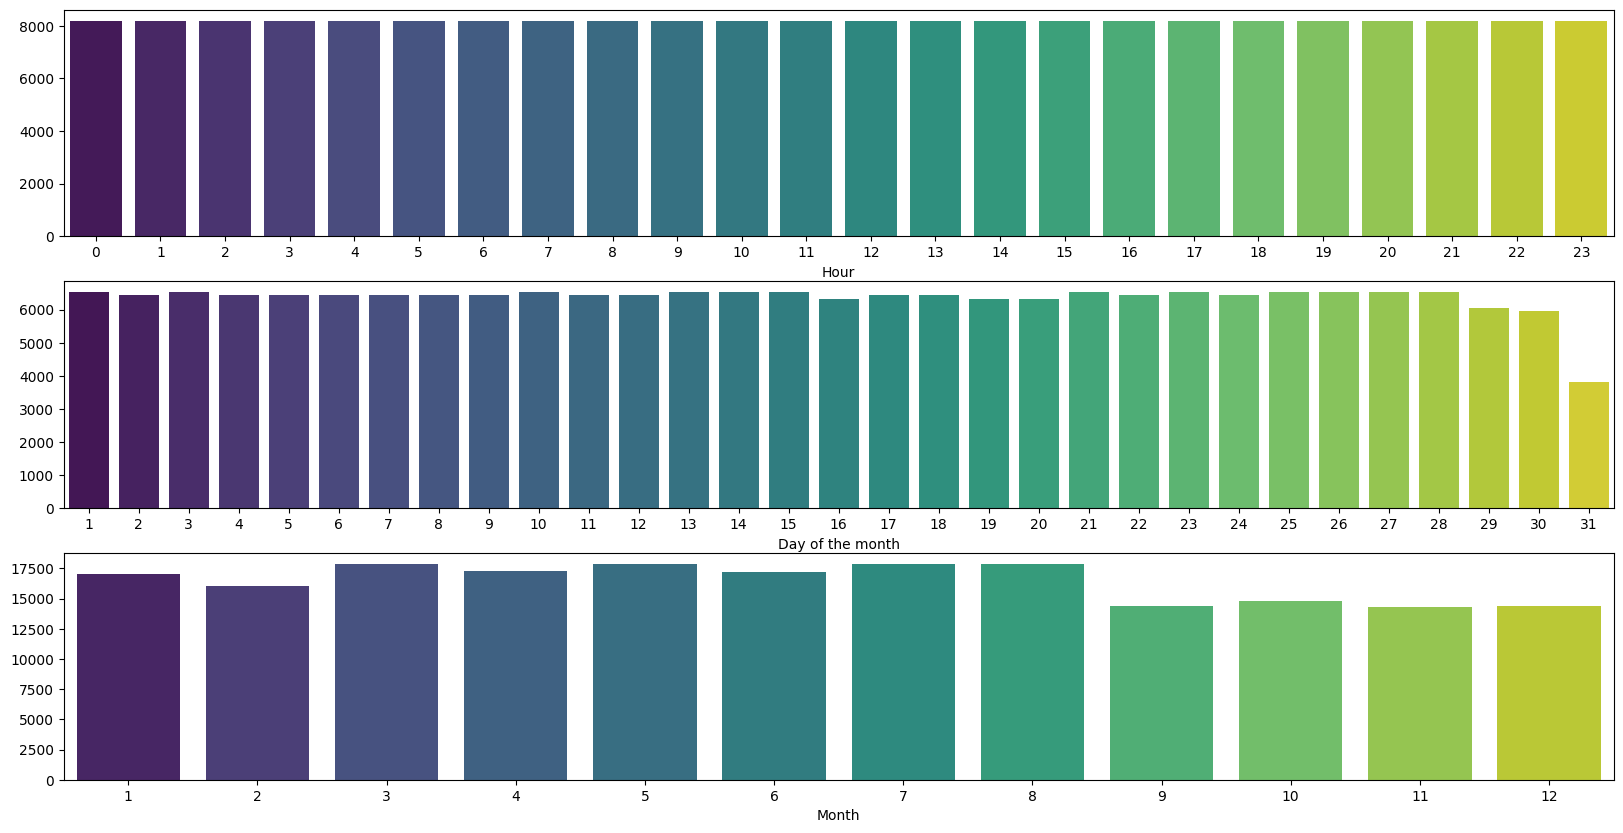

In [22]:
fig, axes = plt.subplots(3, 1, figsize = (20, 10))

hours = df['Time'].dt.hour
count_hours = hours.value_counts()
sns.barplot(x = count_hours.index, y = count_hours.values, ax = axes[0], palette = 'viridis')
axes[0].set_xlabel('Hour')

days = df['Time'].dt.day
count_days = days.value_counts()
sns.barplot(x = count_days.index, y = count_days.values, ax = axes[1], palette = 'viridis')
axes[1].set_xlabel('Day of the month')

months = df['Time'].dt.month
count_months = months.value_counts()
sns.barplot(x = count_months.index, y = count_months.values, ax = axes[2], palette = 'viridis')
axes[2].set_xlabel('Month')

plt.show()

In [5]:
ts_df = df[['Time', 'temp', 'Energy delta[Wh]']].copy()

ts_df['date'] = pd.to_datetime(ts_df['Time'].dt.date)

ts_df = ts_df.drop(columns = ['Time'])

display(ts_df.head(10))

,temp,Energy delta[Wh],date
0,1.6,0,2017-01-01
1,1.6,0,2017-01-01
2,1.6,0,2017-01-01
3,1.6,0,2017-01-01
4,1.7,0,2017-01-01
5,1.7,0,2017-01-01
6,1.7,0,2017-01-01
7,1.7,0,2017-01-01
8,1.9,0,2017-01-01
9,1.9,0,2017-01-01


In [6]:
dates_df = ts_df.groupby(['date'])[['temp']].agg([max, min, np.mean])

dates_df = dates_df.reset_index()

dates_df.columns = ['date', 'max_temp', 'min_temp', 'avg_temp']

dates_df.set_index('date', inplace = True)

display(dates_df)

,max_temp,min_temp,avg_temp
date,,,
2017-01-01,3.9,1.6,2.975000
2017-01-02,2.5,-2.2,0.850000
2017-01-03,4.7,-2.3,1.420833
2017-01-04,2.8,-1.3,1.166667
2017-01-10,-2.0,-7.8,-3.854167
...,...,...,...
2022-08-27,26.6,17.1,21.191667
2022-08-28,22.0,13.2,18.829167
2022-08-29,20.8,12.9,16.525000


In [7]:
lagged_df = dates_df.copy()

shifted = 4

cols_X = list()

for feature in lagged_df.columns:
    for lag in range(1, shifted+1):
        lagged_df[f'{feature}_lag{lag}'] = lagged_df[feature].shift(lag)
        cols_X.append(f'{feature}_lag{lag}')

display(lagged_df)

,max_temp,min_temp,avg_temp,max_temp_lag1,max_temp_lag2,max_temp_lag3,max_temp_lag4,min_temp_lag1,min_temp_lag2,min_temp_lag3,min_temp_lag4,avg_temp_lag1,avg_temp_lag2,avg_temp_lag3,avg_temp_lag4
date,,,,,,,,,,,,,,,
2017-01-01,3.9,1.6,2.975000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2017-01-02,2.5,-2.2,0.850000,3.9,NaN,NaN,NaN,1.6,NaN,NaN,NaN,2.975000,NaN,NaN,NaN
2017-01-03,4.7,-2.3,1.420833,2.5,3.9,NaN,NaN,-2.2,1.6,NaN,NaN,0.850000,2.975000,NaN,NaN
2017-01-04,2.8,-1.3,1.166667,4.7,2.5,3.9,NaN,-2.3,-2.2,1.6,NaN,1.420833,0.850000,2.975000,NaN
2017-01-10,-2.0,-7.8,-3.854167,2.8,4.7,2.5,3.9,-1.3,-2.3,-2.2,1.6,1.166667,1.420833,0.850000,2.975000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-27,26.6,17.1,21.191667,29.7,26.7,23.3,22.7,18.7,17.9,17.8,16.7,22.975000,21.783333,20.437500,19.529167
2022-08-28,22.0,13.2,18.829167,26.6,29.7,26.7,23.3,17.1,18.7,17.9,17.8,21.191667,22.975000,21.783333,20.437500
2022-08-29,20.8,12.9,16.525000,22.0,26.6,29.7,26.7,13.2,17.1,18.7,17.9,18.829167,21.191667,22.975000,21.783333


In [8]:
X = lagged_df.reset_index()[cols_X][shifted:]
y = lagged_df.reset_index()[['max_temp', 'min_temp', 'avg_temp']][shifted:]
dates = dates_df.index[shifted:]

In [9]:
display(X)

,max_temp_lag1,max_temp_lag2,max_temp_lag3,max_temp_lag4,min_temp_lag1,min_temp_lag2,min_temp_lag3,min_temp_lag4,avg_temp_lag1,avg_temp_lag2,avg_temp_lag3,avg_temp_lag4
4,2.8,4.7,2.5,3.9,-1.3,-2.3,-2.2,1.6,1.166667,1.420833,0.850000,2.975000
5,-2.0,2.8,4.7,2.5,-7.8,-1.3,-2.3,-2.2,-3.854167,1.166667,1.420833,0.850000
6,1.7,-2.0,2.8,4.7,-9.2,-7.8,-1.3,-2.3,-5.333333,-3.854167,1.166667,1.420833
7,3.0,1.7,-2.0,2.8,0.6,-9.2,-7.8,-1.3,2.058333,-5.333333,-3.854167,1.166667
8,0.8,3.0,1.7,-2.0,-0.0,0.6,-9.2,-7.8,0.295833,2.058333,-5.333333,-3.854167
...,...,...,...,...,...,...,...,...,...,...,...,...
2045,29.7,26.7,23.3,22.7,18.7,17.9,17.8,16.7,22.975000,21.783333,20.437500,19.529167
2046,26.6,29.7,26.7,23.3,17.1,18.7,17.9,17.8,21.191667,22.975000,21.783333,20.437500
2047,22.0,26.6,29.7,26.7,13.2,17.1,18.7,17.9,18.829167,21.191667,22.975000,21.783333
2048,20.8,22.0,26.6,29.7,12.9,13.2,17.1,18.7,16.525000,18.829167,21.191667,22.975000


In [10]:
splitter = lambda array, size: (array[:size].copy(), array[size:].copy())S

def model_result(model, X, y, dates, model_name, train_size = 0.5, scaling = False):
    size = int(X.shape[0] * train_size)
    
    train_X, test_X = splitter(X, size)
    train_y, test_y = splitter(y, size)
    train_dates, test_dates = splitter(dates, size)
    
    if scaling:
        scaler = StandardScaler()
        train_X = scaler.fit_transform(train_X)
        test_X = scaler.transform(test_X)
        
    model.fit(train_X, train_y)
    
    train_pred = pd.DataFrame(model.predict(train_X), columns = y.columns)
    test_pred = pd.DataFrame(model.predict(test_X), columns = y.columns)
    
    fig, axes = plt.subplots(3, 1, figsize = (12, 24))
    
    for target, ax in zip(y.columns, axes):
        train_r2 = r2_score(train_y[target], train_pred[target])
        train_mse = mse(train_y[target], train_pred[target])
        
        sns.lineplot(
            x = train_dates,
            y = train_pred[target],
            ax = ax, 
            label = 'Train',
            color = 'DarkBlue'
        )
        
        test_r2 = r2_score(test_y[target], test_pred[target])
        test_mse = mse(test_y[target], test_pred[target])
    
        sns.lineplot(
            x = test_dates,
            y = test_pred[target],
            ax = ax, 
            label = 'Test',
            color = 'DarkGreen'
        )
        
        title = f'{model_name} {target} prediction\n'
        title += f'train r2 score = {train_r2} - test r2 score = {test_r2}\n'
        title += f'train mse = {train_mse} - test mse = {test_mse}'
    
        ax.set_title(title)
        
        sns.scatterplot(x = dates, y = y[target], ax = ax, color = 'black')
        
    plt.show()

In [11]:
lgbr = LGBMRegressor(num_leaves = 13, n_estimators = 94, learning_rate = 0.11)

lgbr_multiout = MultiOutputRegressor(lgbr)

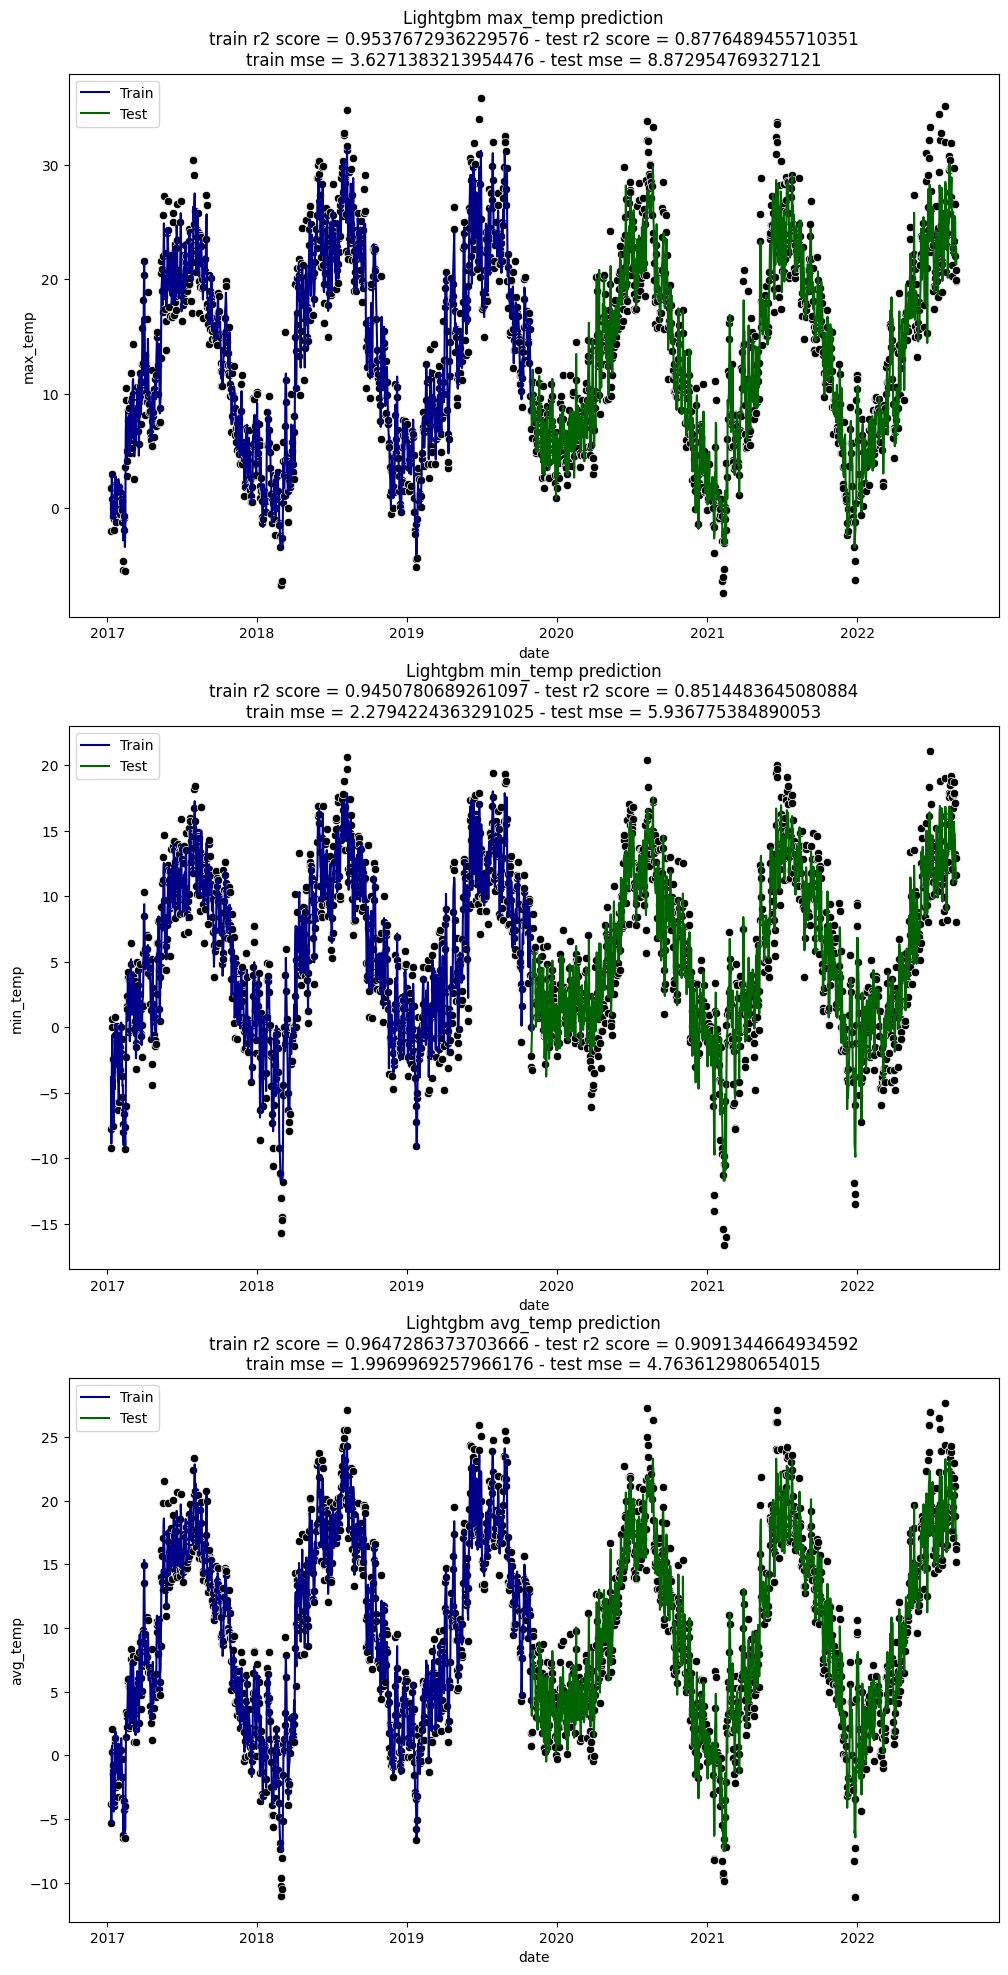

In [12]:
model_result(lgbr_multiout, X, y, dates, 'Lightgbm')

In [13]:
forest = RandomForestRegressor(random_state = 1, max_leaf_nodes = 64, n_estimators = 114, n_jobs = 4)

forest_multiout = MultiOutputRegressor(forest)

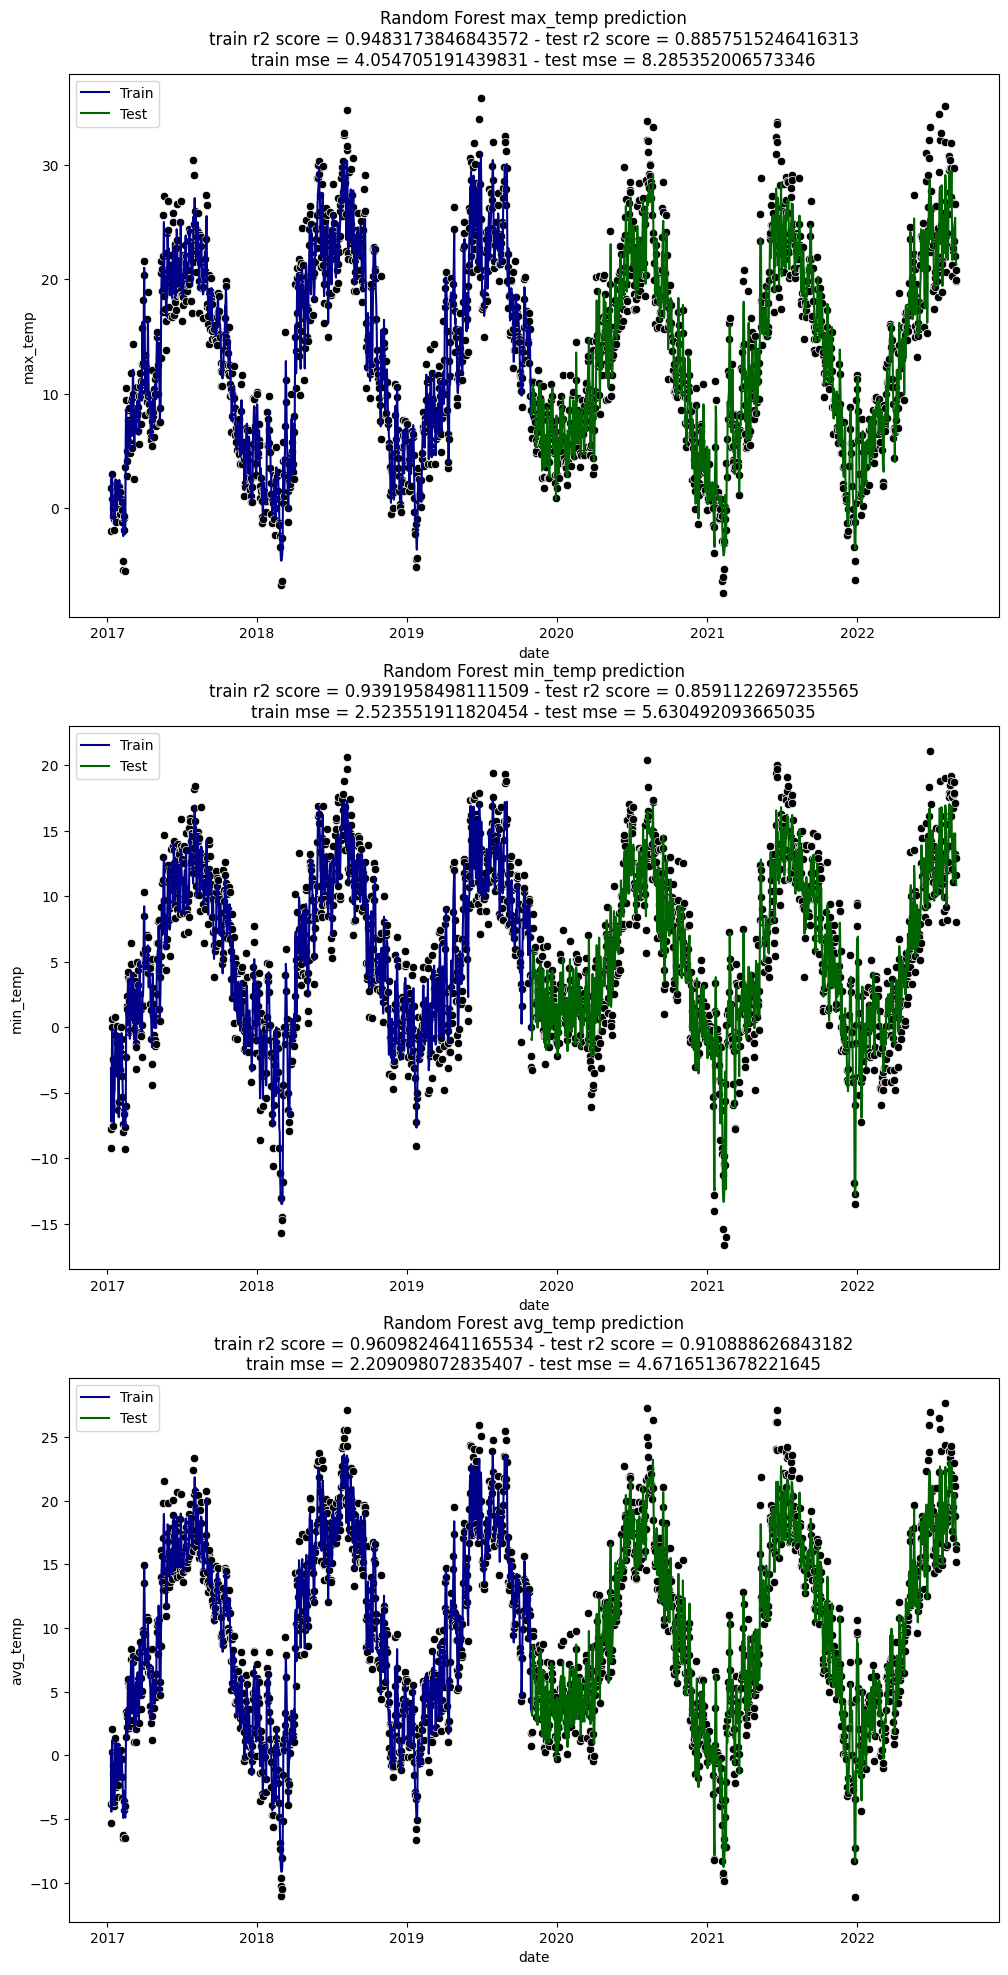

In [14]:
model_result(forest_multiout, X, y, dates, 'Random Forest')

In [15]:
svr = SVR(C = 1, gamma = 0.1)

svr_multiout = MultiOutputRegressor(svr, n_jobs = 2)

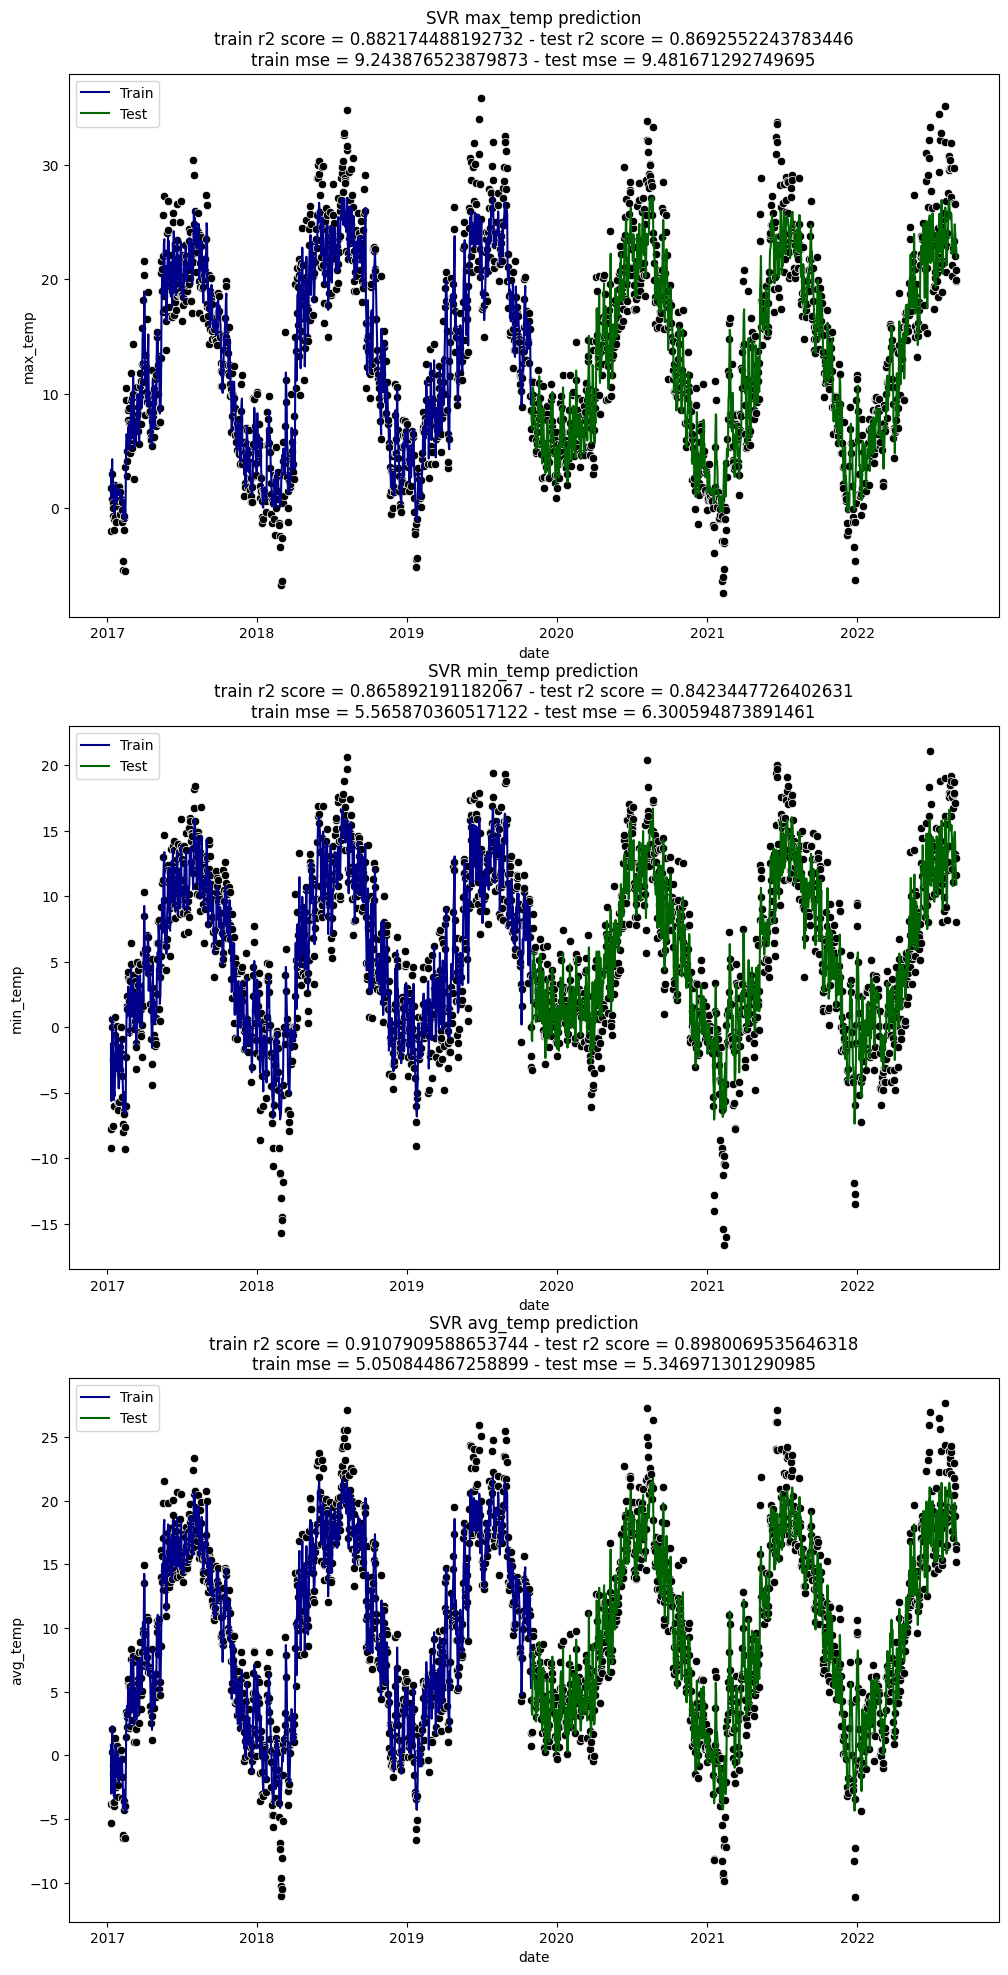

In [16]:
model_result(svr_multiout, X, y, dates, 'SVR', scaling = True)

In [23]:
early_stopping = callbacks.EarlyStopping(patience = 5)

nn = Sequential([
        layers.Dense(64, input_shape = [X.shape[1]], activation = 'relu'),
        layers.Dense(16),
        layers.Dense(16),
        layers.Dense(y.shape[1])
     ])

nn.compile(optimizer = 'adam', loss = 'mse', metrics = ['mae'])

scikeras_model = KerasRegressor(nn, epochs = 104, batch_size = 16, verbose = 0, callbacks = [early_stopping])

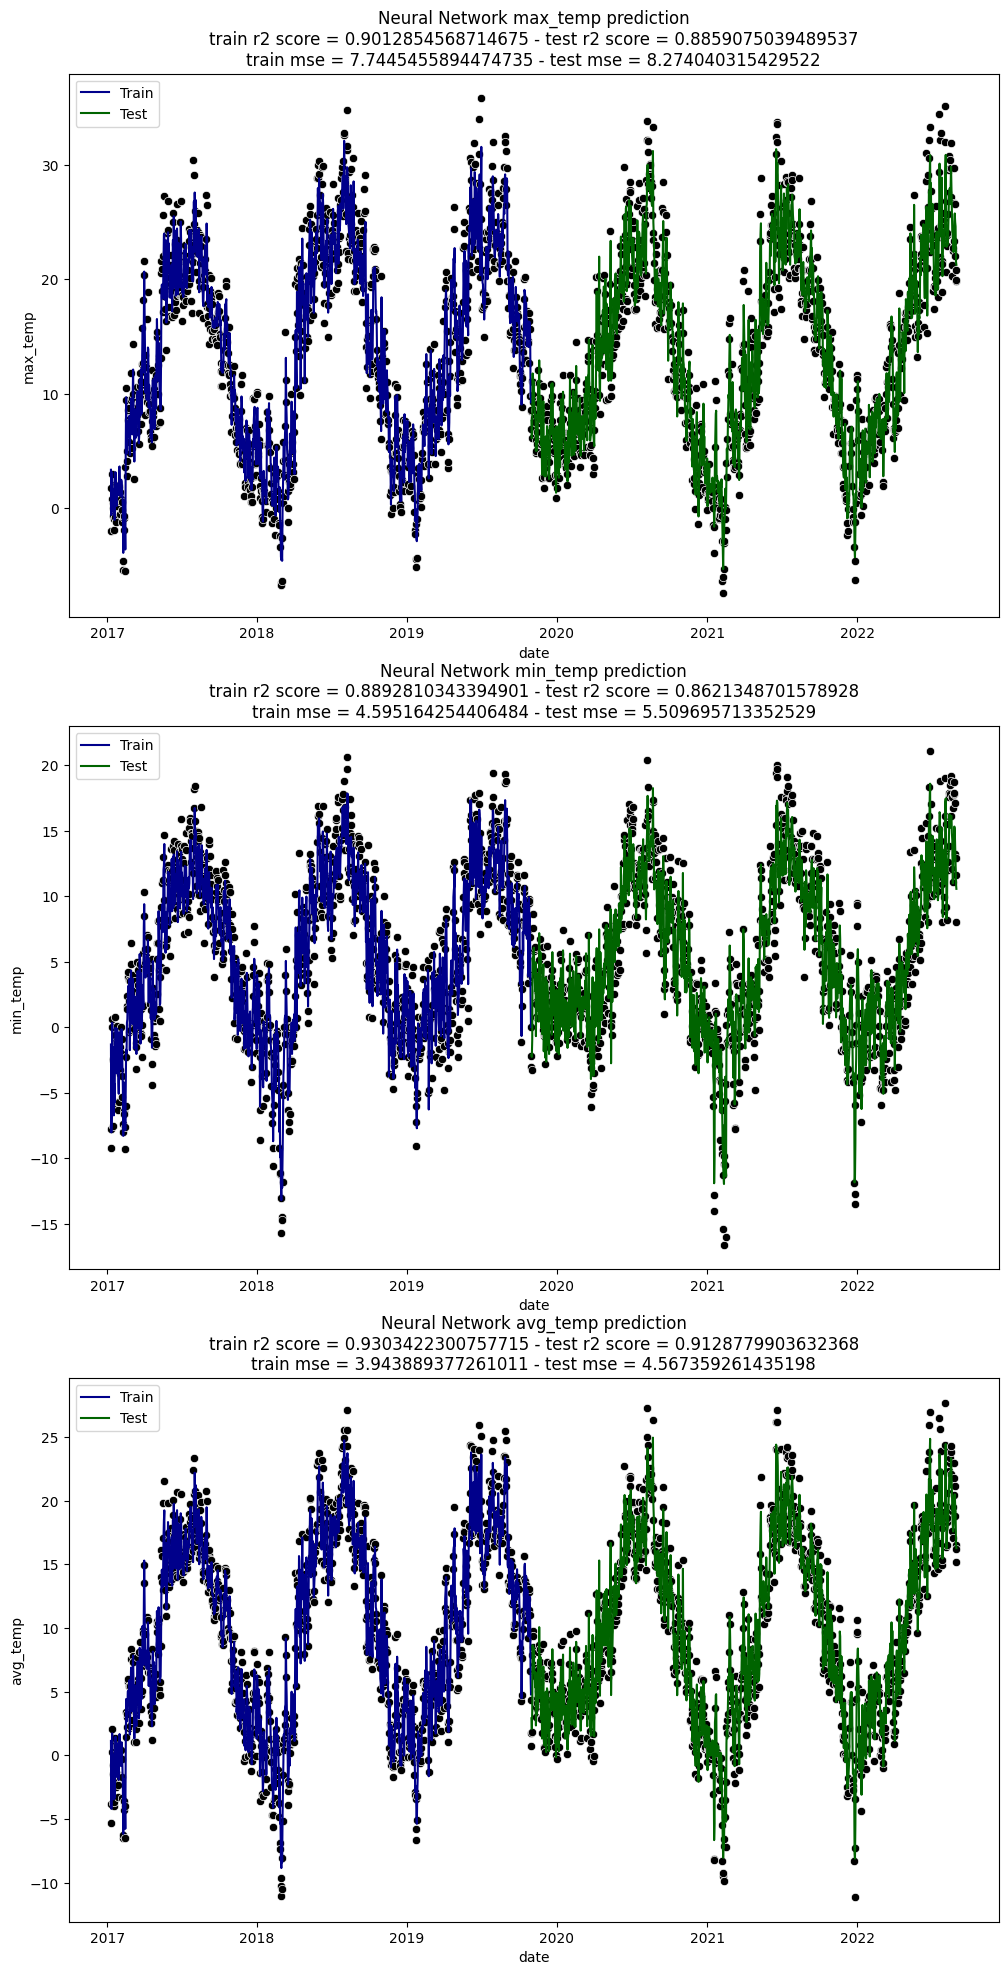

In [24]:
model_result(scikeras_model, X, y, dates, 'Neural Network', scaling = True)

In [19]:
# torch_nn = torch.nn.Sequential(
#              torch.nn.Linear(in_features = X.shape[1], out_features = 4), 
#              torch.nn.ReLU(), 
#              torch.nn.Linear(in_features = 4, out_features = 4), 
#              torch.nn.ReLU(), 
#              torch.nn.Linear(in_features = 4, out_features = 1) 
#            )

# loss_function = torch.nn.MSELoss()
# optimizer = torch.optim.Adam(torch_nn.parameters())

# skorch_model = NeuralNetRegressor(torch_nn, optimizer = torch.optim.Adam, max_epochs = 34, lr = 0.1, verbose = 0)

In [20]:
# # model_result(skorch_model, torch.tensor(X.values), torch.tensor(y.values), dates, 'PyTorch Neural Network', scaling = True)

# nn_splitter = lambda array, size: (array[:size], array[size:])
# model_name = 'PyTorch Neural Network'

# model = skorch_model

# nn_X = torch.tensor(X.values)
# nn_y = torch.tensor(y.values)

# train_size = 0.5

# scaling = True

# size = int(X.shape[0] * train_size)

# train_X, test_X = nn_splitter(nn_X, size)
# train_y, test_y = nn_splitter(nn_y, size)
# train_dates, test_dates = splitter(dates, size)

# if scaling:
#     scaler = StandardScaler()
#     train_X = scaler.fit_transform(train_X)
#     test_X = scaler.transform(test_X)

# model.fit(train_X, train_y)

# train_pred = pd.DataFrame(model.predict(train_X), columns = y.columns)
# test_pred = pd.DataFrame(model.predict(test_X), columns = y.columns)

# fig, axes = plt.subplots(3, 1, figsize = (12, 24))

# for target, ax in zip(y.columns, axes):
#     train_r2 = r2_score(train_y[target], train_pred[target])
#     train_mse = mse(train_y[target], train_pred[target])

#     sns.lineplot(
#         x = train_dates,
#         y = train_pred[target],
#         ax = ax, 
#         label = 'Train',
#         color = 'DarkBlue'
#     )

#     test_r2 = r2_score(test_y[target], test_pred[target])
#     test_mse = mse(test_y[target], test_pred[target])

#     sns.lineplot(
#         x = test_dates,
#         y = test_pred[target],
#         ax = ax, 
#         label = 'Test',
#         color = 'DarkGreen'
#     )

#     title = f'{model_name} {target} prediction\n'
#     title += f'train r2 score = {train_r2} - test r2 score = {test_r2}\n'
#     title += f'train mse = {train_mse} - test mse = {test_mse}'

#     ax.set_title(title)

#     sns.scatterplot(x = dates, y = y[target], ax = ax, color = 'black')

# plt.show()